## Dinoising Diffusion Model

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as tt
import json
import re
import string
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import Vocab
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

# importing torch.optim and torch.nn.functional
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
#from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

print(torch.__version__)
print(torchvision.__version__)

# Create a SummaryWriter
writer = SummaryWriter()

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
device

2.0.1
0.15.1


device(type='mps')

In [3]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [3]:
IMAGE_SIZE = 64
BATCH_SIZE = 14
DATASET_REPETITIONS = 5
LOAD_MODEL = False

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

# optimization
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50

In [4]:
# import Flowers102 dataset

from torchvision.datasets import Flowers102
from torchvision.datasets import CIFAR10

# define the transforms
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    #transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5), (0.5,0.5,0.5))


])

# downloading and creating the dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
#train_dataset = Flowers102(root='./data', split='train', download=True, transform=transform)





Files already downloaded and verified


In [5]:
len(train_dataset)

50000

ValueError: num must be an integer with 1 <= num <= 5, not 6

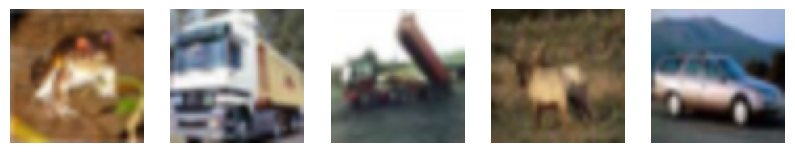

In [7]:
# showing the first 10 images
fig = plt.figure(figsize=(10, 10))
for i in range(10):
    image, label = train_dataset[i]
    image = image.permute(1, 2, 0)

    # unnormalize
    image = (image + 1) / 2

    # make images bigger
    #image = image * 255
    
    fig.add_subplot(1, 5, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

In [8]:
# check the size of images
image, label = train_dataset[2]
image.shape


torch.Size([3, 64, 64])

In [9]:
# check the minimum and maximum values of the images
image, label = train_dataset[0]
print(image.min(), image.max())


tensor(-0.9922) tensor(0.9765)


In [5]:
# creating a dataloader and dropping the last batch
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)


## Forward Noising Process

* The forward noising process is defined as follows:
1. $x_0 \sim p(x_0)$
2. $x_t = \sqrt{1 - \beta_t^2}x_{t-1} + \beta_t \epsilon_{t-1}$
3. If we assume $\epsilon_t \sim \mathcal{N}(0, I)$, then $x_t \sim \mathcal{N}(0, \Sigma_t)$, where $\Sigma_t = \sum_{i=0}^{t-1} \beta_i^2 I$

Formual for q(x_t|x_{t-1}) is given by:
$$q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t^2}x_{t-1}, \beta_t^2 I)$$

This reads:
q of x_t given x_t-1 is a normal distribution with mean $\sqrt(1-beta_t^2) * x_t-1 and variance beta_t^2 * I

## Diffusion Schedules

* Diffusion schedules are defined by $\beta_t$.

There are 3 main types of diffusion schedules:
1. Linear
2. Cosine
3. Cosine with offset

In [11]:
# Define a function that generates a linear diffusion schedule given a set of diffusion times
def linear_diffusion_schedule(diffusion_times):
    # Define the minimum and maximum diffusion rates
    min_rate = 0.0001
    max_rate = 0.02
    
    # calculate the diffusion rates for each time step using a linear interpolation between the minimum and maximum rates
    betas = min_rate + diffusion_times * (max_rate - min_rate)
    
    # Calculate the complement of each diffusion rate
    alpha = 1 - betas
    
    # Calculate the cumulative product of the complement of each diffusion rate
    alpha_bars = torch.cumprod(alpha, dim=0)
    
    # Calculate the signal and noise rates for each time step
    signal_rates = alpha_bars
    noise_rates = 1 - alpha_bars    

    # Return the signal and noise rates
    return signal_rates, noise_rates

In [12]:
def cosine_diffusion_schedule(diffusion_times):
    signal_rates = torch.cos(torch.tensor(diffusion_times) * np.pi / 2)
    noise_rates = torch.sin(torch.tensor(diffusion_times) * np.pi / 2)
    return signal_rates, noise_rates

In [13]:
def offset_cosine_diffusion_schedule(diffusion_times):
    min_signal_rate = 0.02
    max_signal_rate = 0.95
    start_angle = torch.acos(torch.tensor(max_signal_rate))
    end_angle = torch.acos(torch.tensor(min_signal_rate)) # acos is a function that returns the angle whose cosine is the given number

    diffusion_angles = start_angle + torch.tensor(diffusion_times) * (end_angle - start_angle)

    signal_rates = torch.cos(diffusion_angles)
    noise_rates = torch.sin(diffusion_angles)

    return noise_rates, signal_rates

![](2023-06-30-13-18-25.png)

/var/folders/l0/978kqtls1gb5jnv3rvxtjpvh0000gn/T/ipykernel_93542/2618698850.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signal_rates = torch.cos(torch.tensor(diffusion_times) * np.pi / 2)
/var/folders/l0/978kqtls1gb5jnv3rvxtjpvh0000gn/T/ipykernel_93542/2618698850.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_rates = torch.sin(torch.tensor(diffusion_times) * np.pi / 2)
/var/folders/l0/978kqtls1gb5jnv3rvxtjpvh0000gn/T/ipykernel_93542/1945252060.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diffusion_angles = start_

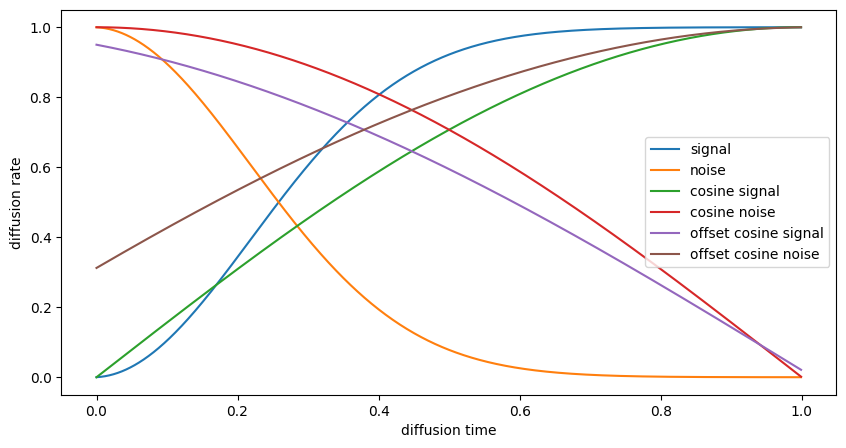

In [14]:
T = 1000
diffusion_times = torch.tensor([x/T for x in range(T)])
linear_noise_rates, linear_signal_rates = linear_diffusion_schedule(diffusion_times)

cosign_noise_rates, cosign_signal_rates = cosine_diffusion_schedule(diffusion_times)

offset_cosign_noise_rates, offset_cosign_signal_rates = offset_cosine_diffusion_schedule(diffusion_times)

# plot the diffusion schedule
plt.figure(figsize=(10, 5))
plt.plot(diffusion_times, linear_signal_rates, label='signal')
plt.plot(diffusion_times, linear_noise_rates, label='noise')

# plot the diffusion schedule for cosine
plt.plot(diffusion_times, cosign_signal_rates, label='cosine signal')
plt.plot(diffusion_times, cosign_noise_rates, label='cosine noise')

# plot the diffusion schedule for offset cosine
plt.plot(diffusion_times, offset_cosign_signal_rates, label='offset cosine signal')
plt.plot(diffusion_times, offset_cosign_noise_rates, label='offset cosine noise')

plt.xlabel('diffusion time')
plt.ylabel('diffusion rate')

plt.legend()

/var/folders/l0/978kqtls1gb5jnv3rvxtjpvh0000gn/T/ipykernel_93542/2618698850.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signal_rates = torch.cos(torch.tensor(diffusion_times) * np.pi / 2)
/var/folders/l0/978kqtls1gb5jnv3rvxtjpvh0000gn/T/ipykernel_93542/2618698850.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_rates = torch.sin(torch.tensor(diffusion_times) * np.pi / 2)
/var/folders/l0/978kqtls1gb5jnv3rvxtjpvh0000gn/T/ipykernel_93542/1945252060.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diffusion_angles = start_

IndexError: index 4 is out of bounds for axis 1 with size 4

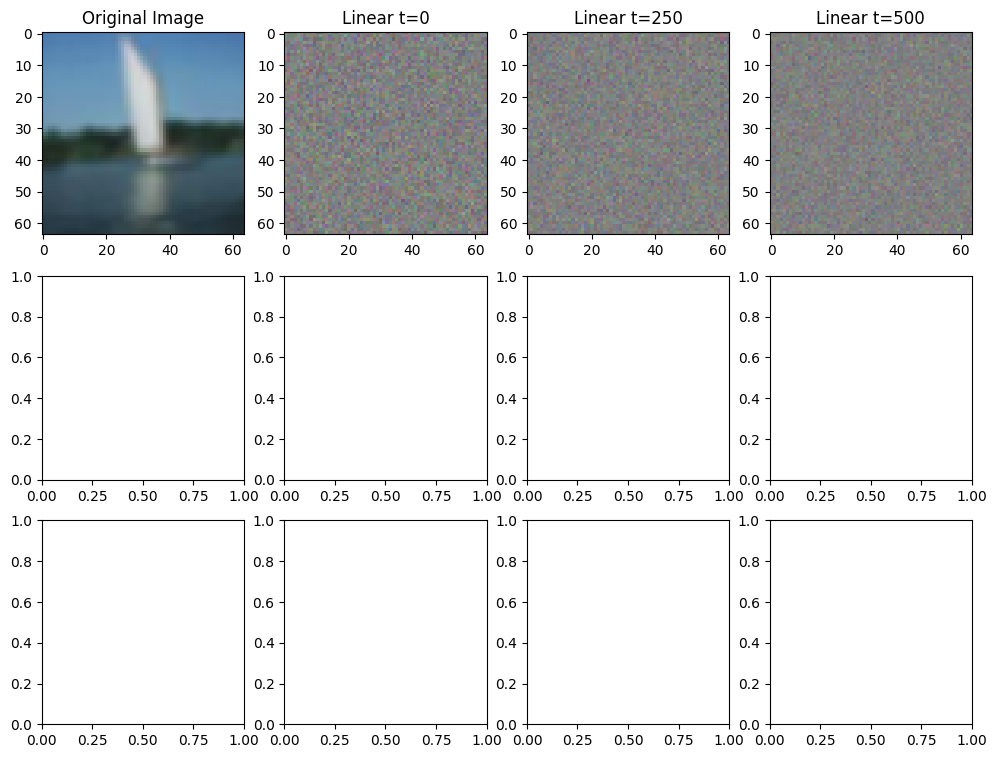

In [15]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def forward_noising_process(image, noise_rates, signal_rates):
    T = len(noise_rates)
    noisy_images = []
    for t in range(T):
        noise = torch.randn_like(image) * np.sqrt(noise_rates[t]/100)  # Scale down the noise level
        image = signal_rates[t] * image + noise
        noisy_images.append(image)
    return noisy_images

# Define the diffusion schedules
T = 1000
diffusion_times = torch.tensor([x/T for x in range(T)])
linear_noise_rates, linear_signal_rates = linear_diffusion_schedule(diffusion_times)
cosine_noise_rates, cosine_signal_rates = cosine_diffusion_schedule(diffusion_times)
offset_cosine_noise_rates, offset_cosine_signal_rates = offset_cosine_diffusion_schedule(diffusion_times)

# Get a batch of images from the dataloader
images, _ = next(iter(train_loader))

# Select the first image from the batch
image = images[0]

# Apply the forward noising process for each diffusion schedule
linear_noisy_images = forward_noising_process(image.clone(), linear_noise_rates, linear_signal_rates)
cosine_noisy_images = forward_noising_process(image.clone(), cosine_noise_rates, cosine_signal_rates)
offset_cosine_noisy_images = forward_noising_process(image.clone(), offset_cosine_noise_rates, offset_cosine_signal_rates)

# Function to normalize image for display
def normalize_image(image):
    return image.permute(1, 2, 0).detach().numpy() * 0.5 + 0.5

# Display the original image and some of the noisy images for each diffusion schedule
fig, axs = plt.subplots(3, 4, figsize=(12, 9))

# Linear schedule
axs[0, 0].imshow(normalize_image(image))
axs[0, 0].set_title('Original Image')
for i, t in enumerate([0, T//4, T//2, T-1]):  # Show the image at the start, quarter, half, and end of the diffusion process
    axs[0, i+1].imshow(normalize_image(linear_noisy_images[t]))
    axs[0, i+1].set_title(f'Linear t={t}')

# Cosine schedule
axs[1, 0].imshow(normalize_image(image))
axs[1, 0].set_title('Original Image')
for i, t in enumerate([0, T//4, T//2, T-1]):
    axs[1, i+1].imshow(normalize_image(cosine_noisy_images[t]))
    axs[1, i+1].set_title(f'Cosine t={t}')

# Offset cosine schedule
axs[2, 0].imshow(normalize_image(image))
axs[2, 0].set_title('Original Image')
for i, t in enumerate([0, T//4, T//2, T-1]):
    axs[2, i+1].imshow(normalize_image(offset_cosine_noisy_images[t]))
    axs[2, i+1].set_title(f'Offset Cosine t={t}')

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()


## The Reverse Diffusion Process

* The reverse diffusion process is defined as follows:
1. $x_T \sim p(x_T)$


## Building a Diffusion Model

In [6]:
# coding the diffusion tools / process in a class

class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02,img_size=64, device='mps'):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        betas = torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
        return betas
    
    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1.0 - self.alpha_hat[t])[:, None, None, None]
        gaussian_noise = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * gaussian_noise, gaussian_noise
    
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))
    
    def sample(self, model, n, labels, cfg_scale=3):
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x



## Creating the UNET model

In [7]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())


class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


In [8]:
class UNet_conditional(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=None, device="mps"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, y):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [9]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

In [10]:
import copy


def train(dataloader, epochs=300):
    model = UNet_conditional(num_classes=10).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.003)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=64, device=device)
    writer = SummaryWriter()
    l = len(dataloader)
    ema = EMA(beta=0.995)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False)

    for epoch in range(epochs):
        
        pbar = tqdm(dataloader)
        for i, (images, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            if np.random.random() < 0.1:
                labels = None
            predicted_noise = model(x_t, t, labels)
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ema.step_ema(ema_model, model)

            pbar.set_postfix(MSE=loss.item())
            writer.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

            # print every epoch
        print(f"Epoch {epoch} MSE: {loss.item()}")

        sampled_images = diffusion.sample(model, n=images.shape[0])
        # save model every 50 epochs
        if epoch % 10 == 0:
            labels = torch.arange(10).long
            sampled_images = diffusion.sample(model, n=images.shape[0], labels=labels)
            ema_sampled_images = diffusion.sample(ema_model, n=images.shape[0], labels=labels)
            plot_images(sampled_images)
            save_images(sampled_images, f"/Users/parkermoesta/Generative_models/Generative_models/Diffusion Models/images/CDIFFmodel_{epoch}.png", nrow=8)
            save_images(ema_sampled_images, f"/Users/parkermoesta/Generative_models/Generative_models/Diffusion Models/images/CDIFFmodel_ema_{epoch}.png", nrow=8)
            torch.save(model.state_dict(), f"/Users/parkermoesta/Generative_models/Generative_models/Diffusion Models/models/CDIFFmodel_{epoch}.pt")
            torch.save(ema_model.state_dict(), f"/Users/parkermoesta/Generative_models/Generative_models/Diffusion Models/models/CDIFFmodel_ema_{epoch}.pt")


In [11]:
train(train_loader, epochs=300)

/var/folders/l0/978kqtls1gb5jnv3rvxtjpvh0000gn/T/ipykernel_96670/2856829885.py:13: UserWarning: The operator 'aten::cumprod.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  self.alpha_hat = torch.cumprod(self.alpha, dim=0)
  0%|          | 1/3571 [00:36<35:46:39, 36.08s/it, MSE=1.31]